# Transfer Learning

Usar transfer learning para clasificar las imágenes en la carpeta datasets. Comparen los resultados
del modelo si se tiene en cuenta el mejor resultado o los mejores dos por predicción.

In [92]:
# Importamos las librerias necesarias
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras import models, layers


### Carga de Dataset

In [108]:
# Definiendo las constantes del tamaño de la imagen, tamaño del batch y canales de la imagen

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

Cargar un set de entrenamiento y validación usando la función
image_dataset_from_directory de tensorflow.keras.preprocessing (asignar un tamaño a las
imágenes).

In [109]:
# Usamos la funcion image_dataset_from_directory para cargar el dataset

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory="./data/datasets",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE,
)

Found 333 files belonging to 5 classes.


In [110]:
# Mostramos las clases del dataset

class_names = dataset.class_names
n_classes = len(class_names)
print(class_names)

['cats', 'chicken', 'dogs', 'hamster', 'horse']


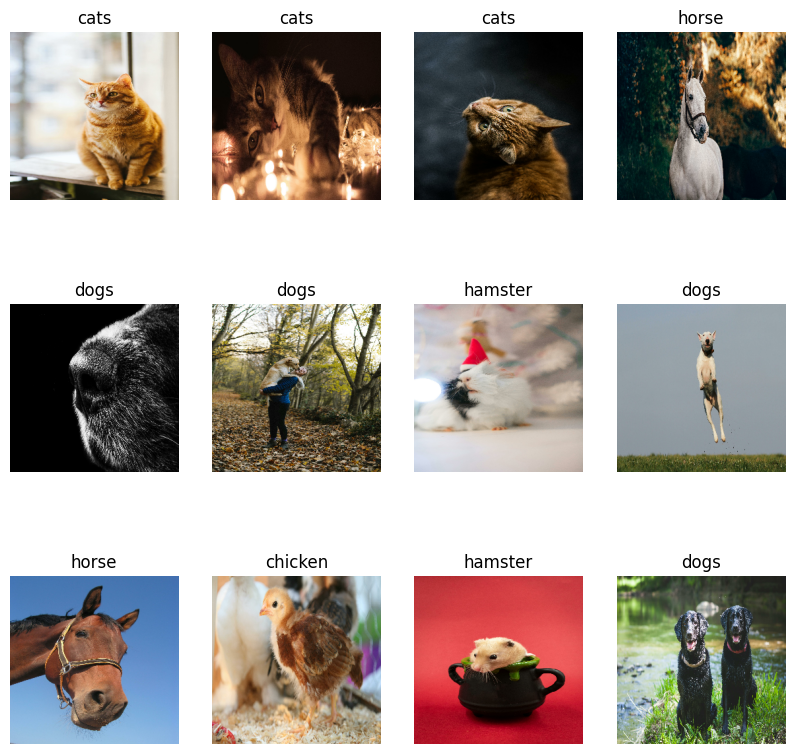

In [111]:
# Mostramos las primeras 12 imagenes del dataset

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [97]:
# Creamos una funcion para generar un set de train y uno de validacion

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2,  shuffle=True, shuffle_size=10000):
    if shuffle:
        # Se mezclan los datos
        ds = ds.shuffle(shuffle_size, seed=12)
    # Se obtiene el tamaño de los sets
    train_size = int(len(ds) * train_split)
    val_size = int(len(ds) * val_split)
    # Se dividen los sets
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    return train_ds, val_ds

In [116]:
# Obtenemos los sets de train y validacion
train_ds, val_ds = get_dataset_partitions_tf(dataset)
# Mostramos el tamaño de los sets
len(train_ds), len(val_ds)


(8, 2)

In [99]:
# Aplicamos cache y prefetch a los sets para mejorar la velocidad de entrenamiento
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Data Augmentation

In [100]:
# Definimos un resize y rescale para las imagenes
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [101]:
# Definimos la data augmentation con RandomFlip y RandomRotation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

### Transfer Learning

In [102]:
# Cargamos el modelo pre-entrenado InceptionV3
inception = tf.keras.applications.InceptionV3(
    input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS),
    include_top=False, 
    weights='imagenet')
# Congelamos la última capa
inception.trainable = False

In [103]:
# Creamos el modelo con las capas de InceptionV3 y tres capas adicionales
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    inception,
    tf.keras.layers.GlobalAveragePooling2D(), #GlobalAveragePooling2D Capa
    tf.keras.layers.Flatten(),  # Capa de aplanamiento
    tf.keras.layers.Dropout(rate=0.1), #Capa Dropout 
    tf.keras.layers.Dense(32,activation = 'relu'), #Capa Dense
    tf.keras.layers.Dropout(rate=0.1), #Capa Dropout
    tf.keras.layers.Dense(n_classes,activation = 'softmax')
])

In [104]:
# Definimo el input_shape
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# Compilamos el modelo
model.build(input_shape)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 sequential_11 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_4  (32, 2048)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_4 (Flatten)         (32, 2048)                0         
                                                                 
 dropout_12 (Dropout)        (32, 2048)                0         
                                                     

In [105]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [117]:
EPOCHS = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1
    
)

Epoch 1/20
8/8 [==============================] - ETA: 0s - loss: 1.2635 - accuracy: 0.4979

/home/tavera/projects/assignment-TL/assignment-TL/venv/lib/python3.8/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8/8 [==============================] - 23s 2s/step - loss: 1.2635 - accuracy: 0.4979 - val_loss: 0.7804 - val_accuracy: 0.8750
Epoch 2/20
8/8 [==============================] - 26s 2s/step - loss: 0.9770 - accuracy: 0.6160 - val_loss: 0.5666 - val_accuracy: 0.9219
Epoch 3/20
8/8 [==============================] - 26s 2s/step - loss: 0.8052 - accuracy: 0.7422 - val_loss: 0.4410 - val_accuracy: 0.8906
Epoch 4/20
8/8 [==============================] - 24s 2s/step - loss: 0.6643 - accuracy: 0.7722 - val_loss: 0.3509 - val_accuracy: 0.8906
Epoch 5/20
8/8 [==============================] - 26s 2s/step - loss: 0.6046 - accuracy: 0.7695 - val_loss: 0.2270 - val_accuracy: 0.9531
Epoch 6/20
8/8 [==============================] - 25s 2s/step - loss: 0.6234 - accuracy: 0.7637 - val_loss: 0.1907 - val_accuracy: 0.9844
Epoch 7/20
8/8 [==============================] - 24s 2s/step - loss: 0.6031 - accuracy: 0.8017 - val_loss: 0.2778 - val_accuracy: 0.9219
Epoch 8/20
8/8 [=============================

In [118]:
# Obtenemos el accuracy y la perdida del modelo
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [119]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

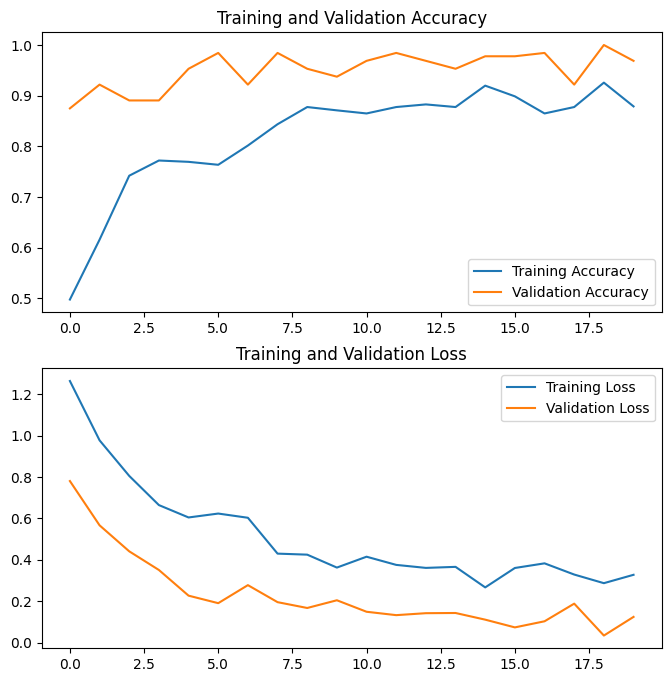

In [120]:
# Graficamos el accuracy y la perdida del modelo
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

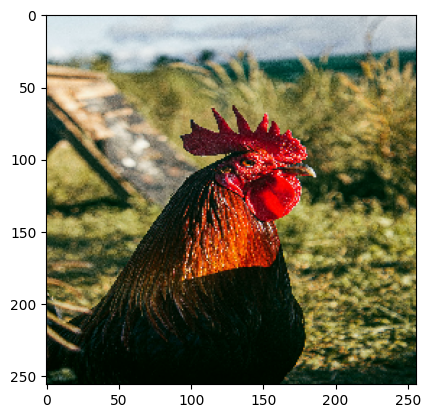

Actual Label: chicken
1/1 [==============================] - 1s 1s/step
Predicted Label: chicken


In [121]:
# Mostramos la prediccion de una imagen del set de validacion
for image_batch, labels_batch in val_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0]

    plt.imshow(first_image)
    plt.show()
    print(f"Actual Label: {class_names[first_label]}")

    batch_prediction = model.predict(image_batch)
    print(f"Predicted Label: {class_names[tf.argmax(batch_prediction[0]).numpy()]}")

In [122]:
# Creamos una funcion para predecir una imagen
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[tf.argmax(predictions[0]).numpy()]
    confidence = round(100 * (tf.math.reduce_max(predictions).numpy()), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 46ms/step


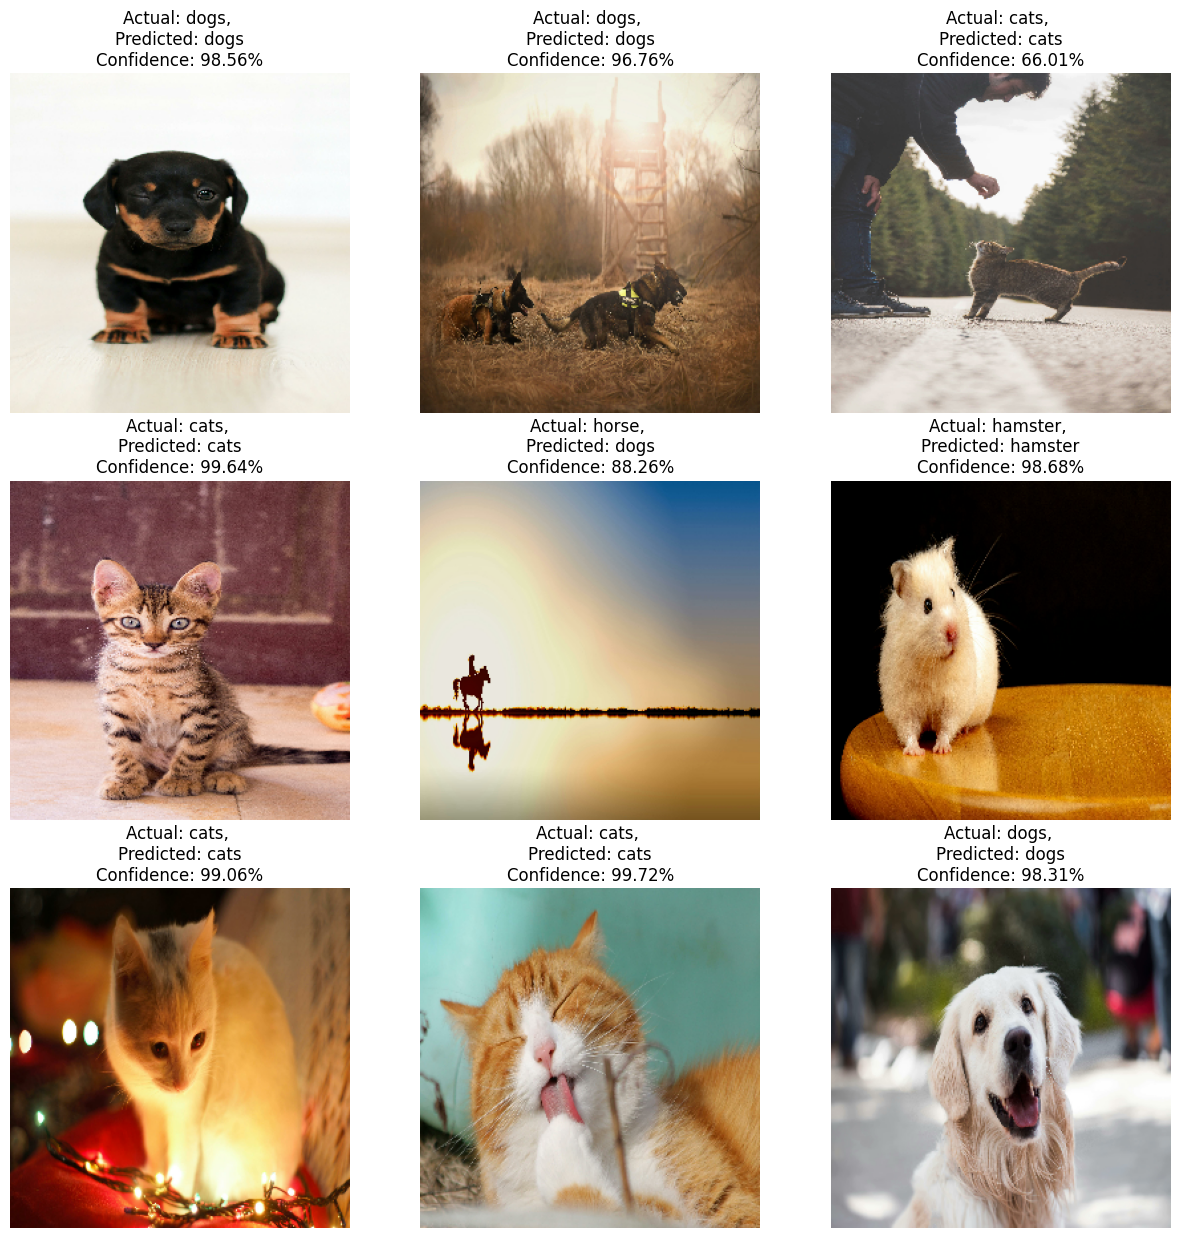

In [123]:
# Mostramos las predicciones de las primeras 9 imagenes del set de validacion
plt.figure(figsize=(15, 15))
for images, labels in val_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")

In [129]:
# Convertimos el dataset a un array de numpy para calcular las métricas para el top 1 y top 2
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image, label in dataset:
        images.append(image.numpy())
        labels.append(label.numpy())
    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

# Obtenemos los sets de train y validacion en arrays de numpy
x_train, y_train = dataset_to_numpy(train_ds)
x_val, y_val = dataset_to_numpy(val_ds)

In [125]:
print("Evaluate on test data")
results = model.evaluate(x_val, y_val, batch_size=32)

Evaluate on test data
2/2 [==============================] - 1s 575ms/step - loss: 0.0950 - accuracy: 0.9844


In [126]:
def evaluate_top_2_metrics(model, x_data, y_data):
    # Make predictions
    logits = model.predict(x_data)
    predictions = tf.nn.softmax(logits).numpy()
    
    # Get top 2 predictions
    top_two = np.argsort(predictions, axis=1)[:, -2:][:, ::-1]
    
    # Convert top_two predictions to the same shape as y_data for metric calculations
    y_pred_top2 = np.zeros_like(y_data)
    
    for i in range(len(y_data)):
        if y_data[i] in top_two[i]:
            y_pred_top2[i] = y_data[i]
        else:
            y_pred_top2[i] = top_two[i, 0]
    
    # Calculate precision, recall, and F1-score
    precision = precision_score(y_data, y_pred_top2, average='macro')
    recall = recall_score(y_data, y_pred_top2, average='macro')
    f1 = f1_score(y_data, y_pred_top2, average='macro')
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_data, y_pred_top2)
    
    
    return {
        "top_2_precision": precision,
        "top_2_recall": recall,
        "top_2_f1_score": f1,
        "top_2_confusion_matrix": conf_matrix
    }

evaluate_top_2_metrics(model, x_val, y_val)

2/2 [==============================] - 1s 625ms/step


{'top_2_precision': 1.0,
 'top_2_recall': 1.0,
 'top_2_f1_score': 1.0,
 'top_2_confusion_matrix': array([[19,  0,  0,  0,  0],
        [ 0, 11,  0,  0,  0],
        [ 0,  0, 14,  0,  0],
        [ 0,  0,  0,  9,  0],
        [ 0,  0,  0,  0, 11]])}

In [127]:
def evaluate_normal_metrics(model, x_data, y_data):
    # Make predictions
    logits = model.predict(x_data)
    predictions = tf.nn.softmax(logits).numpy()
    
    # Get top-1 predictions
    top_one = np.argmax(predictions, axis=1)
    
    # Calculate precision, recall, and F1-score
    precision = precision_score(y_data, top_one, average='macro')
    recall = recall_score(y_data, top_one, average='macro')
    f1 = f1_score(y_data, top_one, average='macro')
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_data, top_one)
    
    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": conf_matrix
    }

evaluate_normal_metrics(model, x_val, y_val)

2/2 [==============================] - 1s 615ms/step


{'precision': 0.9866666666666667,
 'recall': 0.9818181818181818,
 'f1_score': 0.9835796387520526,
 'confusion_matrix': array([[19,  0,  0,  0,  0],
        [ 0, 11,  0,  0,  0],
        [ 0,  0, 14,  0,  0],
        [ 0,  0,  0,  9,  0],
        [ 0,  0,  1,  0, 10]])}